# Appendix, Performance with fixed intrinsic parameters

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import StrMethodFormatter

import seaborn as sns

import a.lib.dataloader as dl
from a.lib.tools import dist, lpf, converged

In [2]:
# Set figure aesthetics
sns.set_context("notebook")
sns.set_style("ticks")
fs = 14
seeds_n = 30

## LIF

In [3]:
# Load Data
data = dl.DataLoader("./a/results/", "adam").merge()

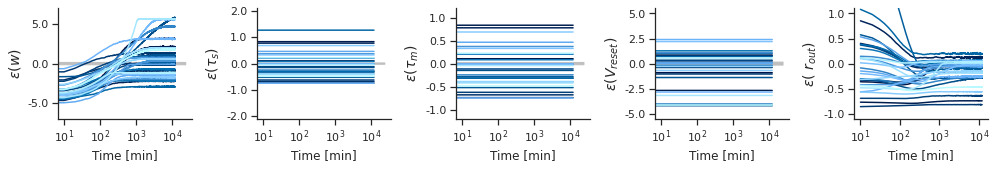

In [4]:
sns.set_palette(['#001649', '#001d50', '#002359', '#002a61', '#00316a', '#003872', '#00407a',
                 '#004783', '#004f8b', '#005694', '#005e9d', '#0066a5', '#006dae', '#0e75b7',
                 '#227cbf', '#3084c7', '#3b8bcf', '#4593d7', '#4f9adf', '#59a2e8', '#62aaf0',
                 '#6bb2f9', '#74bafe', '#7ec3ff', '#88ccff', '#91d5ff', '#9bdeff', '#a5e7ff',
                 '#aef0ff', '#b7f9ff'])

training_steps = len(data["tau_s"][0]) * 10
x = np.linspace(0., training_steps, len(data["tau_s"][0]))

fig, axs = plt.subplots(1, 5, figsize=(14, 2.5))
for i in range(data["ws"].shape[0]):
    scatter_x = data["ws"][i].shape[1] * 1.1
    axs[0].semilogx(x, dist(data["ws"][i].T, data["ws_target"][i]))
    axs[1].semilogx(x, dist(data["tau_s"][i], data["tau_s_target"][i]))
    axs[2].semilogx(x, dist(data["tau_m"][i], data["tau_m_target"][i]))
    axs[3].semilogx(x, dist(data["v_reset"][i], data["v_reset_target"][i]))
    axs[4].semilogx(x[1:], dist(lpf(data["firing_rate"][i][1:], 0.1), data["firing_rate_target"][i]))

axs[0].set_ylim([-7., 7.])
axs[1].set_ylim([-2.1, 2.1])
axs[2].set_ylim([-1.2, 1.2])
axs[3].set_ylim([-5.5, 5.5])
axs[4].set_ylim([-1.1, 1.1])

for i in [0, 3]:
    axs[i].fill_between(x * 2., 0.15, -0.15, color=[0.75, 0.75, 0.75])
for i in [1, 2]:
    axs[i].fill_between(x * 2., 0.025, -0.025, color=[0.75, 0.75, 0.75])  

axs[0].set_ylabel("$\epsilon (w)$", fontsize=fs)
axs[1].set_ylabel("$\epsilon (\\tau_s)$", fontsize=fs)
axs[2].set_ylabel("$\epsilon (\\tau_m)$", fontsize=fs)
axs[3].set_ylabel("$\epsilon (V_{reset})$ ", fontsize=fs)
axs[4].set_ylabel("$\epsilon (\ r_{out})$", fontsize=fs)

for i in range(5):
    axs[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

for i in range(5):
    sns.despine(ax=axs[i])
    axs[i].set_xlabel("Time [min]")
    axs[i].set_xticks([10., 100., 1000., 10000.])

fig.tight_layout()

fig.savefig("appendix-fixed-parameters-lif-trajectories.svg", pad_inches=0.)

-2ms:  0.08465273113481873
-1ms:  0.12651788310818016
Hits:  0.18477098213312057  +/-  0.007886418749041172  SE
+1ms:  0.1261904140178159
+2ms:  0.07445543951780653


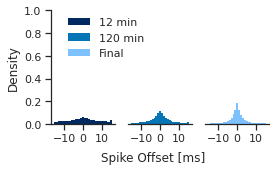

In [5]:
training_steps = len(data["tau_s"][0]) * 10

# Create divergence histograms
hists = {0: [], 1: [], 2: []}

for k in range(seeds_n):
    student_spike_times_1 = data["eval_0_student"][k]
    student_spike_times_2 = data["eval_1_student"][k]
    student_spike_times_3 = data["eval_100_student"][k]

    teacher_spike_times_1 = data["eval_0_teacher"][k]
    teacher_spike_times_2 = data["eval_1_teacher"][k]
    teacher_spike_times_3 = data["eval_100_teacher"][k]

    for i, (student_spike_times, teacher_spike_times) in enumerate([(student_spike_times_1, teacher_spike_times_1), (student_spike_times_2, teacher_spike_times_2), (student_spike_times_3, teacher_spike_times_3)]):
        diffs = []
        for student_spike in student_spike_times:
            nearest_teacher_spike = np.argmin(np.abs(teacher_spike_times - student_spike))
            diffs.append(student_spike - teacher_spike_times[nearest_teacher_spike])
        hist = np.histogram(diffs, density=True, bins=31, range=(-15, 16))[0]
        if np.any(np.isnan(hist)):
            continue
        hists[i].append(hist)

# Plot
colors = sns.color_palette(['#002a61', '#0675b6', '#7dc2ff'])

fig, axs = plt.subplots(1, 3, figsize=(4., 2.5))
for i in range(3):
    if i == 0:
        label = str(int(0.001*training_steps)) + " min"
    elif i == 1:
        label = str(int(.01*training_steps)) + " min"
    else:
        label = "Final"
    axs[i].bar(np.linspace(-15, 15, 31), np.mean(hists[i], axis=0), label=label, color=colors[i], linewidth=0, width=1.)
    sns.despine(ax=axs[i], left=i>0)
    if i > 0.:
        axs[i].set_yticks([])
    axs[i].set_ylim(0., 1.)
axs[0].set_ylabel("Density")
axs[0].set_xlabel(" ")
fig.text(0.55, 0.07, "Spike Offset [ms]", ha="center")
fig.legend(loc=(0.23, 0.63), frameon=False)
fig.tight_layout()

fig.savefig("appendix-fixed-parameters-lif-summary.svg", pad_inches=0.)

print("-2ms: ", np.mean(hists[2], axis=0)[13])
print("-1ms: ", np.mean(hists[2], axis=0)[14])
print("Hits: ", np.mean(hists[2], axis=0)[15], " +/- ", np.std(np.mean(hists[2], axis=0)) / np.sqrt(seeds_n), " SE")
print("+1ms: ", np.mean(hists[2], axis=0)[16])
print("+2ms: ", np.mean(hists[2], axis=0)[17])

In [6]:
# Load data
data = dl.DataLoader("./b/results/", "adam").merge()

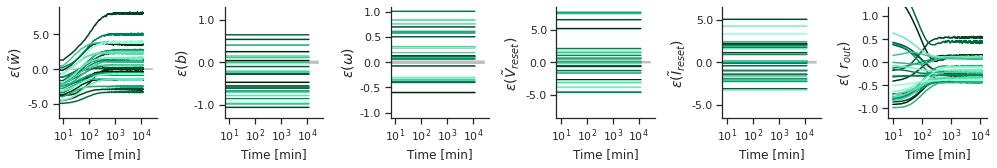

In [11]:
sns.set_palette(sns.color_palette("flare", n_colors=seeds_n))

sns.set_palette(['#002100', '#002702', '#002e0c', '#003414', '#003b1b', '#004221', '#004a27',
                 '#00512d', '#005834', '#00603a', '#006841', '#006f48', '#00774f', '#007f57',
                 '#00875e', '#008f65', '#00976d', '#049f74', '#1ba77c', '#29af83', '#34b78a',
                 '#3ebf92', '#48c799', '#51cfa1', '#5ad7a9', '#63e0b0', '#6ce8b8', '#74f0c0',
                 '#7df8c8', '#8effd8'])

training_steps = len(data["b"][0]) * 10
x = np.linspace(0., training_steps, len(data["b"][0]))

fig, axs = plt.subplots(1, 6, figsize=(14, 2.5))
for i in range(data["ws"].shape[0]):
    scatter_x = data["ws"][i].shape[1] * 1.1
    axs[0].semilogx(x, dist(data["ws"][i].T, data["ws_target"][i]))
    axs[1].semilogx(x, dist(data["b"][i], data["b_target"][i]))
    axs[2].semilogx(x, dist(data["omega"][i], data["omega_target"][i]))
    axs[3].semilogx(x, dist(data["v_reset"][i], data["v_reset_target"][i]))
    axs[4].semilogx(x, dist(data["i_reset"][i], data["i_reset_target"][i]))
    axs[5].semilogx(x[1:], dist(lpf(data["firing_rate"][i][1:], 0.1), data["firing_rate_target"][i]))

axs[0].set_ylim([-7., 9.])
axs[1].set_ylim([-1.3, 1.3])
axs[2].set_ylim([-1.1, 1.1])
axs[3].set_ylim([-8.5, 8.5])
axs[4].set_ylim([-6.5, 6.5])
axs[5].set_ylim([-1.2, 1.2])

for i in [0]:
    axs[i].fill_between(x * 2.3, 0.05, -0.05, color=[0.75, 0.75, 0.75])
for i in [1, 2]:
    axs[i].fill_between(x * 2.3, 0.025, -0.025, color=[0.75, 0.75, 0.75])  
for i in [3, 4]:
    axs[i].fill_between(x * 2.3, 0.1, -0.1, color=[0.75, 0.75, 0.75])

axs[0].set_ylabel("$\epsilon (\\tilde{w})$", fontsize=fs)
axs[1].set_ylabel("$\epsilon (b)$", fontsize=fs)
axs[2].set_ylabel("$\epsilon (\omega)$", fontsize=fs)
axs[3].set_ylabel("$\epsilon (\\tilde{V}_{reset})$ ", fontsize=fs)
axs[4].set_ylabel("$\epsilon (\\tilde{I}_{reset})$ ", fontsize=fs)
axs[5].set_ylabel("$\epsilon (\ r_{out})$", fontsize=fs)

for i in range(6):
    axs[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

for i in range(6):
    sns.despine(ax=axs[i])
    axs[i].set_xlabel("Time [min]")
    axs[i].set_xticks([10., 100., 1000., 10000.])

fig.tight_layout()

fig.savefig("appendix-fixed-parameters-lrf-trajectories.svg", pad_inches=0.)

-2ms:  0.08193074647472813
-1ms:  0.10938388019314157
Hits:  0.12857405058488033  +/-  0.005863522620088482  SE
+1ms:  0.0883481480181283
+2ms:  0.05820509260550813


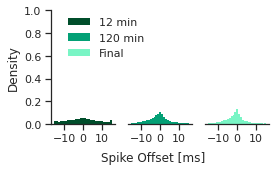

In [8]:
# Create divergence histograms
hists = {0: [], 1: [], 2: []}

for k in range(seeds_n):
    student_spike_times_1 = data["eval_0_student"][k]
    student_spike_times_2 = data["eval_1_student"][k]
    student_spike_times_3 = data["eval_100_student"][k]

    teacher_spike_times_1 = data["eval_0_teacher"][k]
    teacher_spike_times_2 = data["eval_1_teacher"][k]
    teacher_spike_times_3 = data["eval_100_teacher"][k]

    for i, (student_spike_times, teacher_spike_times) in enumerate([(student_spike_times_1, teacher_spike_times_1), (student_spike_times_2, teacher_spike_times_2), (student_spike_times_3, teacher_spike_times_3)]):
        diffs = []
        for student_spike in student_spike_times:
            nearest_teacher_spike = np.argmin(np.abs(teacher_spike_times - student_spike))
            diffs.append(student_spike - teacher_spike_times[nearest_teacher_spike])
        hist = np.histogram(diffs, density=True, bins=31, range=(-15, 16))[0]
        if np.any(np.isnan(hist)):
            continue
        hists[i].append(hist)

# Plot
colors = sns.color_palette(['#004e2b', '#03a075', '#79f5c5'])

fig, axs = plt.subplots(1, 3, figsize=(4., 2.5))
for i in range(3):
    if i == 0:
        label = str(int(0.001*training_steps)) + " min"
    elif i == 1:
        label = str(int(.01*training_steps)) + " min"
    else:
        label = "Final"
    axs[i].bar(np.linspace(-15, 15, 31), np.mean(hists[i], axis=0), label=label, color=colors[i], linewidth=0, width=1.)
    sns.despine(ax=axs[i], left=i>0)
    if i > 0.:
        axs[i].set_yticks([])
    axs[i].set_ylim(0., 1.)
axs[0].set_ylabel("Density")
axs[0].set_xlabel(" ")
fig.text(0.55, 0.07, "Spike Offset [ms]", ha="center")
fig.legend(loc=(0.23, 0.63), frameon=False)
fig.tight_layout()

fig.savefig("appendix-fixed-parameters-lrf-summary.svg", pad_inches=0.)

print("-2ms: ", np.mean(hists[2], axis=0)[13])
print("-1ms: ", np.mean(hists[2], axis=0)[14])
print("Hits: ", np.mean(hists[2], axis=0)[15], " +/- ", np.std(np.mean(hists[2], axis=0)) / np.sqrt(seeds_n), " SE")
print("+1ms: ", np.mean(hists[2], axis=0)[16])
print("+2ms: ", np.mean(hists[2], axis=0)[17])